# Where were we?


- Airbnb data - predicting asset's price.

- Last results:  
    Mean Absolute Error (Σ|y-pred|/n): 0.315  
    Mean Squared Error (Σ(|y-pred|/y)/n): 0.182  
    Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.427  

# What we worked on since last time:

1. Handled previously ignored dates columns  
2. Swithced from linear regression model into xgboost 
3. Better filling of nan values
4.  

In [117]:
import datetime
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import xgboost as xg
import matplotlib.pyplot as plt
import shutil
import requests
import math

In [118]:
data = pd.read_csv('dataset/train.csv')

The following cell will serve us for fixed partition to train and test during the following examinations:

In [119]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [120]:
count = (data['beds'] == 0).sum()
print('zero values', count)
data = data[data['beds'] > 0]
count = (data['beds'] == 0).sum()
print('zero values', count)

zero values 4
zero values 0


In [121]:
data['split'] = np.random.randn(data.shape[0], 1)
msk = np.random.rand(len(data)) <= 0.8


data = data.drop('split', axis=1)

## 1 Handled previously ignored dates columns:

Although those columns are dates, they do not define a time series dataset.   
They should be handled in their own specific way. 
We chose to convert each date cell into a numeric type that represents years from the given date untill today.

At first, we filled nan values with very old date, while assuming that the older the assets or its reviews, it will worth less

In [122]:
data['host_since'] = data['host_since'].fillna('2000-01-22')
data['first_review'] = data['first_review'].fillna('2000-01-22')
data['last_review'] = data['last_review'].fillna('2000-01-22')

In [123]:
# host_since
data.host_since = pd.to_datetime(data.host_since, format='%Y-%m-%d')
data['host_since_in_years'] = datetime.datetime.now() - data['host_since']
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x.days)
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x/365)
data.host_since_in_years = pd.to_numeric(data.host_since_in_years)
data = data.drop('host_since', axis=1)

# first_review
data.first_review = pd.to_datetime(data.first_review, format='%Y-%m-%d')
data['first_review_in_years'] = datetime.datetime.now() - data['first_review']
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x.days)
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x/365)
data.first_review_in_years = pd.to_numeric(data.first_review_in_years)
data = data.drop('first_review', axis=1)

# last_review
data.last_review = pd.to_datetime(data.last_review, format='%Y-%m-%d')
data['last_review_in_years'] = datetime.datetime.now() - data['last_review']
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x.days)
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x/365)
data.last_review_in_years = pd.to_numeric(data.last_review_in_years)
data = data.drop('last_review', axis=1)

check if there is zero values in bed column

In [124]:
#

In [125]:
train = data[msk]
test = data[~msk]

In [126]:
train[['log_price','host_since_in_years']].corr()

,log_price,host_since_in_years
log_price,1.000000,0.069765
host_since_in_years,0.069765,1.000000


In [127]:
train[['log_price','first_review_in_years']].corr()

,log_price,first_review_in_years
log_price,1.000000,0.103196
first_review_in_years,0.103196,1.000000


In [128]:
train[['log_price','last_review_in_years']].corr()

,log_price,last_review_in_years
log_price,1.000000,0.093189
last_review_in_years,0.093189,1.000000


In [129]:
binary_variables = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

categorical_variables = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
                         'neighbourhood', 'amenities']

numeric_variables = ['log_price', 'accommodates', 'bathrooms', 'host_response_rate', 'latitude', 'longitude',
                     'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'host_since_in_years', 'first_review_in_years', 'last_review_in_years']  

column_to_drop = ['id', 'name', 'thumbnail_url', 'zipcode', 'description']

columns = {'binary_variables': binary_variables, 'categorical_variables': categorical_variables,
           'numeric_variables': numeric_variables, 'column_to_drop': column_to_drop, 'binned_variables': []}

In [130]:
train.loc[:,'price'] = np.exp(train['log_price'])
test.loc[:,'price'] = np.exp(test['log_price'])

try:
    train.loc[:,'log_price_per_bed'] = np.log(train['price'] / train['beds'])
    test.loc[:, 'log_price_per_bed'] = np.log(test['price'] / test['beds'])
    train.loc[:, 'price_per_bed'] = train['price'] / train['beds']
    test.loc[:, 'price_per_bed'] = test['price'] / test['beds']

except:
    print("error")
numeric_variables.append('log_price_per_bed')
numeric_variables.append('price_per_bed')

numeric_variables.append('price')

d:\users\liels\onedrive\desktop\airbnbprice\venv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


old code for running test prediction:

In [131]:
for column in columns['column_to_drop']:
    train = train.drop(column, axis=1)
    test = test.drop(column, axis=1)
    
for column in columns['binary_variables']:
    train[column] = train[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    test[column] = test[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)

train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0

for column in columns['numeric_variables']:
    train[column] = train[column].astype(float)
    test[column] = test[column].astype(float)

null_columns = []
for column in columns['binary_variables'] + columns['categorical_variables'] + columns['numeric_variables']:
    if train[column].isnull().sum():
        null_columns.append(column)
    if test[column].isnull().sum():
        null_columns.append(column)
        
train_with_most_frequent_values = train.copy()
test_with_most_frequent_values = test.copy()
for column in null_columns:
    val = train_with_most_frequent_values[column].value_counts().index[0]
    train_with_most_frequent_values[column] = train_with_most_frequent_values[column].fillna(val)
    test_with_most_frequent_values[column] = test_with_most_frequent_values[column].fillna(val)

train = train_with_most_frequent_values
test = test_with_most_frequent_values

train = train.reset_index()
test = test.reset_index()

def collect_amenities(data, columns_dict):
    chars_to_remove = '"{}'
    amenities_set = set()
    for line in data['amenities']:
        amenities = line.split(',')
        for obj in amenities:
            for char in chars_to_remove:
                obj = obj.replace(char, "")
            if "translation missing" not in obj and obj != '':
                amenities_set.add(obj)
    for amenity in amenities_set:
        columns_dict['binary_variables'].append(amenity)
    return list(amenities_set)


def create_amenities_array(amenities_list, data):
    amenities_array = []
    for index, row in data.iterrows():
        array = np.zeros(shape=(len(amenities_list)))
        row_amen = data['amenities'][index].split(',')
        for amen in row_amen:
            item = amen.replace('"', '').replace('}', '').replace('{', '')
            if item in amenities_list:
                res = amenities_list.index(item)
                array[res] = 1
        amenities_array.append(array.tolist())

    amenities_df = pd.DataFrame(amenities_array, columns=amenities_list)
    return amenities_df


# converting amenities column to binary columns and updating columns_dict
def create_amenities_cols(data, amenities_set):
    amenities_array = create_amenities_array(amenities_set, data)

    data = data.drop(['amenities'], axis=1)
    data = pd.concat([data, amenities_array], axis=1)

    return data


amenities_list = collect_amenities(train, columns)
train = create_amenities_cols(train, amenities_list)
test = create_amenities_cols(test, amenities_list)
columns['categorical_variables'].remove('amenities')


top_neighbourhoods = train['neighbourhood'].value_counts().head(50).keys()
for index, row in train.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        train.at[index,'neighbourhood'] = 'other'
for index, row in test.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        test.at[index,'neighbourhood'] = 'other'


In [132]:

def get_img_from_url(data):
    for i in range(len(data)):
        # todo move this to clean data
        try:
            if str(data['thumbnail_url'][i]) == 'nan':
                data['brightness'] = 0
                continue
            response = requests.get(data['thumbnail_url'][i], stream=True)
            with open('img.png', 'wb') as out_file:
               shutil.copyfileobj(response.raw, out_file)
            del response
            brightness = get_brightness(data)
            data['brightness'] = brightness
        except:
            data['brightness'] = 0
            print(data['thumbnail_url'][i])
    return data

def get_brightness(data):
    # opens image in current working directory, converts to greyscale, and pulls a float value for brightness
    from PIL import Image, ImageStat
    img_src = Image.open('img.png').convert('L')
    img_src.save("img_greyscale.png") # saving this image to show comparison
    stat = ImageStat.Stat(img_src)
    brightness = stat.mean[0]
    return brightness

# train = get_img_from_url(train)
# test = get_img_from_url(test)
# numeric_variables.append('brightness')
# train = train.drop('thumbnail_url', axis=1)
# test = test.drop('thumbnail_url', axis=1)

In [133]:

col_price_list = ['log_price', 'log_price_per_bed', 'price', 'price_per_bed']
errors_linear_regression = {}
errors_XGBRegressor = {}

In [134]:
def drop_other_price(current, oh_train, oh_test):
    for price in col_price_list:
        if current != price:
            oh_train = oh_train.drop(price, axis=1)
            oh_test = oh_test.drop(price, axis=1)
    oh_train = oh_train.reset_index(drop=True)
    oh_test = oh_test.reset_index(drop=True)
    return oh_train, oh_test

In [135]:
def run(col_price, model):

    # we leave the target feature as is
    oh_train = train[col_price]
    oh_test = test[col_price]

    # now adding the one hot encoded data
    for variable in columns['binned_variables']+columns['categorical_variables']:
        onehot_train_col = pd.get_dummies(train[variable], prefix=variable)
        oh_train = pd.concat([oh_train, onehot_train_col], axis=1)

        onehot_test_col = pd.get_dummies(test[variable], prefix=variable)
        oh_test = pd.concat([oh_test, onehot_test_col], axis=1)

    for col in columns['binary_variables']:
        train[col] = train[col].replace(True, 1)
        train[col] =train[col].replace(False, 0)
        oh_train = pd.concat([oh_train, train[col]], axis=1)

        test[col] = test[col].replace(True, 1)
        test[col] = test[col].replace(False, 0)
        oh_test = pd.concat([oh_test, test[col]], axis=1)


    for col in columns['numeric_variables']:
        if col != col_price:
            oh_train = pd.concat([oh_train, train[col]], axis=1)

            oh_test = pd.concat([oh_test, test[col]], axis=1)

    add_to_test = list(set(oh_train.columns) - set(oh_test.columns))
    add_to_train = list(set(oh_test.columns) - set(oh_train.columns))
    for col in add_to_train:
        oh_train[col] = 0
    for col in add_to_test:
        oh_test[col] = 0

    oh_test = oh_test[oh_train.columns]
    oh_train, oh_test = drop_other_price(col_price, oh_train, oh_test)

    # separate labels from data=
    train_class = oh_train[col_price]
    oh_train_data = oh_train.drop(col_price, axis=1)

    # train the model:
    model.fit(oh_train_data, train_class)
    print(model)


    train_y = oh_train[col_price].values
    train_x = oh_train.drop(col_price, axis=1)
    test_y = oh_test[col_price].values
    test_x = oh_test.drop(col_price, axis=1)

    return train_x, train_y, test_x, test_y, model

In [136]:
linear_regression = linear_model.LinearRegression()
for col_price in col_price_list:
    train_x, train_y, test_x, test_y, linear_regression = run(col_price, linear_regression)
    prediction_test = linear_regression.predict(test_x)
    errors_linear_regression[col_price] = mean_absolute_error(test_y, prediction_test)
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
    print("Mean Squared Error (Σ(|y-pred|/y)/n):",
          "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
          format(np.sqrt(mean_squared_error(test_y, prediction_test))))
    print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

LinearRegression()
Mean Absolute Error (Σ|y-pred|/n): 0.313
Mean Squared Error (Σ(|y-pred|/y)/n): 0.179
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.423
r2 score: 0.652
LinearRegression()
Mean Absolute Error (Σ|y-pred|/n): 0.333
Mean Squared Error (Σ(|y-pred|/y)/n): 0.199
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.447
r2 score: 0.523
LinearRegression()
Mean Absolute Error (Σ|y-pred|/n): 67.266
Mean Squared Error (Σ(|y-pred|/y)/n): 15,113.002
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 122.935
r2 score: 0.472
LinearRegression()
Mean Absolute Error (Σ|y-pred|/n): 40.771
Mean Squared Error (Σ(|y-pred|/y)/n): 5,861.293
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 76.559
r2 score: 0.278


{'log_price': 0.31291421800290403, 'log_price_per_bed': 0.33290861613691736, 'price': 67.26572399006595, 'price_per_bed': 40.770620624155654}


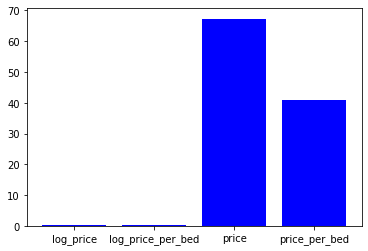

In [137]:
print(errors_linear_regression)
plt.bar(list(errors_linear_regression.keys()), errors_linear_regression.values(), color='b')
plt.show()


### This addition did not cause a significant change.
- should we drop these columns?
- should we think of a better use of the originals columns?
- will a more complex model be more influenced by these columns?

## 2 Swithced from linear regression model into xgboost

In [138]:
# Instantiation
xgb_r = xg.XGBRegressor()

# Fitting the model
for col_price in col_price_list:
    train_x, train_y, test_x, test_y, xgb_r = run(col_price, xgb_r)
#     xgb_r.fit(train_x, train_y)

    # Predict the model
    prediction_test = xgb_r.predict(test_x)
    errors_XGBRegressor[col_price] = mean_absolute_error(test_y, prediction_test)
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
    print("Mean Squared Error (Σ(|y-pred|/y)/n):",
          "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
          format(np.sqrt(mean_squared_error(test_y, prediction_test))))
    print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
Mean Absolute Error (Σ|y-pred|/n): 0.273
Mean Squared Error (Σ(|y-pred|/y)/n): 0.142
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.377
r2 score: 0.724
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_s

{'log_price': 0.27280211115132946, 'log_price_per_bed': 0.27268754510371923, 'price': 52.35106346342388, 'price_per_bed': 33.26201043218812}


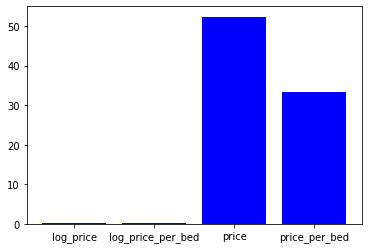

In [139]:
# max_bars = 3
print(errors_XGBRegressor)
plt.bar(list(errors_XGBRegressor.keys()), errors_XGBRegressor.values(), color='b')
plt.show()

## 3 Better filling of nan values

In [140]:
data = pd.read_csv('dataset/train.csv')

# delete from columns bed - rows with zero
count = (data['beds'] == 0).sum()
print('zero values', count)
data = data[data['beds'] > 0]
count = (data['beds'] == 0).sum()
print('zero values', count)


data['host_since'] = data['host_since'].fillna('2000-01-22')
data['first_review'] = data['first_review'].fillna('2000-01-22')
data['last_review'] = data['last_review'].fillna('2000-01-22')
data.host_since = pd.to_datetime(data.host_since, format='%Y-%m-%d')
data['host_since_in_years'] = datetime.datetime.now() - data['host_since']
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x.days)
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x/365)
data.host_since_in_years = pd.to_numeric(data.host_since_in_years)
data = data.drop('host_since', axis=1)

# first_review
data.first_review = pd.to_datetime(data.first_review, format='%Y-%m-%d')
data['first_review_in_years'] = datetime.datetime.now() - data['first_review']
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x.days)
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x/365)
data.first_review_in_years = pd.to_numeric(data.first_review_in_years)
data = data.drop('first_review', axis=1)

# last_review
data.last_review = pd.to_datetime(data.last_review, format='%Y-%m-%d')
data['last_review_in_years'] = datetime.datetime.now() - data['last_review']
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x.days)
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x/365)
data.last_review_in_years = pd.to_numeric(data.last_review_in_years)
data = data.drop('last_review', axis=1)

train = data[msk]
test = data[~msk]


binary_variables = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

categorical_variables = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
                         'neighbourhood', 'amenities']

numeric_variables = ['log_price', 'accommodates', 'bathrooms', 'host_response_rate', 'latitude', 'longitude',
                     'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'host_since_in_years', 'first_review_in_years', 'last_review_in_years']  

column_to_drop = ['id', 'name', 'thumbnail_url', 'zipcode', 'description']

columns = {'binary_variables': binary_variables, 'categorical_variables': categorical_variables,
           'numeric_variables': numeric_variables, 'column_to_drop': column_to_drop, 'binned_variables': []}

for column in columns['column_to_drop']:
    train = train.drop(column, axis=1)
    test = test.drop(column, axis=1)
    
for column in columns['binary_variables']:
    train[column] = train[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    test[column] = test[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0

for column in columns['numeric_variables']:
    train[column] = train[column].astype(float)
    test[column] = test[column].astype(float)
    
null_columns = []
for column in columns['binary_variables'] + columns['categorical_variables'] + columns['numeric_variables']:
    if train[column].isnull().sum():
        null_columns.append(column)
    if test[column].isnull().sum():
        null_columns.append(column)
        


zero values 4
zero values 0


### bathrooms, bedrooms and beds

In [141]:
avg_bath_per_accomm = (train['bathrooms']/train['accommodates']).mean()

train['bathrooms'] = train['bathrooms'].fillna(train['accommodates']*avg_bath_per_accomm)
test['bathrooms'] = test['bathrooms'].fillna(test['accommodates']*avg_bath_per_accomm)
null_columns = list(filter(lambda x : x!='bathrooms', null_columns))


avg_bedrooms_per_accomm = (train['bedrooms']/train['accommodates']).mean()

train['bedrooms'] = train['bedrooms'].fillna(train['accommodates']*avg_bedrooms_per_accomm)
test['bedrooms'] = test['bedrooms'].fillna(test['accommodates']*avg_bedrooms_per_accomm)
null_columns = list(filter(lambda x : x!='bedrooms', null_columns))


avg_beds_per_accomm = (train['beds']/train['accommodates']).mean()

train['beds'] = train['beds'].fillna(train['accommodates']*avg_beds_per_accomm)
test['beds'] = test['beds'].fillna(test['accommodates']*avg_beds_per_accomm)
null_columns = list(filter(lambda x : x!='beds', null_columns))

### neighbourhood

In [142]:
### we have 5473 missing neighborhoods, maybe we can add dict of neighbourhoods center lon lat and check for the closest with some limit to sent it to other


In [143]:
train_with_most_frequent_values = train.copy()
test_with_most_frequent_values = test.copy()
for column in null_columns:
    val = train_with_most_frequent_values[column].value_counts().index[0]
    train_with_most_frequent_values[column] = train_with_most_frequent_values[column].fillna(val)
    test_with_most_frequent_values[column] = test_with_most_frequent_values[column].fillna(val)

train = train_with_most_frequent_values
test = test_with_most_frequent_values

train = train.reset_index()
test = test.reset_index()

def collect_amenities(data, columns_dict):
    chars_to_remove = '"{}'
    amenities_set = set()
    for line in data['amenities']:
        amenities = line.split(',')
        for obj in amenities:
            for char in chars_to_remove:
                obj = obj.replace(char, "")
            if "translation missing" not in obj and obj != '':
                amenities_set.add(obj)
    for amenity in amenities_set:
        columns_dict['binary_variables'].append(amenity)
    return list(amenities_set)


def create_amenities_array(amenities_list, data):
    amenities_array = []
    for index, row in data.iterrows():
        array = np.zeros(shape=(len(amenities_list)))
        row_amen = data['amenities'][index].split(',')
        for amen in row_amen:
            item = amen.replace('"', '').replace('}', '').replace('{', '')
            if item in amenities_list:
                res = amenities_list.index(item)
                array[res] = 1
        amenities_array.append(array.tolist())

    amenities_df = pd.DataFrame(amenities_array, columns=amenities_list)
    return amenities_df


# converting amenities column to binary columns and updating columns_dict
def create_amenities_cols(data, amenities_set):
    amenities_array = create_amenities_array(amenities_set, data)

    data = data.drop(['amenities'], axis=1)
    data = pd.concat([data, amenities_array], axis=1)

    return data

amenities_list = collect_amenities(train, columns)
train = create_amenities_cols(train, amenities_list)
test = create_amenities_cols(test, amenities_list)
columns['categorical_variables'].remove('amenities')

top_neighbourhoods = train['neighbourhood'].value_counts().head(50).keys()
for index, row in train.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        train.at[index,'neighbourhood'] = 'other'
for index, row in test.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        test.at[index,'neighbourhood'] = 'other'
        
# we leave the target feature as is
oh_train = train['log_price']
oh_test = test['log_price']

# now adding the one hot encoded data
for variable in columns['binned_variables']+columns['categorical_variables']:
    onehot_train_col = pd.get_dummies(train[variable], prefix=variable)
    oh_train = pd.concat([oh_train, onehot_train_col], axis=1)

    onehot_test_col = pd.get_dummies(test[variable], prefix=variable)
    oh_test = pd.concat([oh_test, onehot_test_col], axis=1)
    
for col in columns['binary_variables']:
    train[col] = train[col].replace(True, 1)
    train[col] =train[col].replace(False, 0)
    oh_train = pd.concat([oh_train, train[col]], axis=1)

    test[col] = test[col].replace(True, 1)
    test[col] = test[col].replace(False, 0)
    oh_test = pd.concat([oh_test, test[col]], axis=1)
    
for col in columns['numeric_variables']:
    if col != 'log_price':
        oh_train = pd.concat([oh_train, train[col]], axis=1)

        oh_test = pd.concat([oh_test, test[col]], axis=1)
        
add_to_test = list(set(oh_train.columns) - set(oh_test.columns))
add_to_train = list(set(oh_test.columns) - set(oh_train.columns))
for col in add_to_train:
    oh_train[col] = 0
for col in add_to_test:
    oh_test[col] = 0

oh_test = oh_test[oh_train.columns]

train_y = oh_train['log_price'].values
train_x = oh_train.drop('log_price', axis=1)
test_y = oh_test['log_price'].values
test_x = oh_test.drop('log_price', axis=1)



xgb_r = xg.XGBRegressor()
 

xgb_r.fit(train_x, train_y)
 

prediction_test = xgb_r.predict(test_x)

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

Mean Absolute Error (Σ|y-pred|/n): 0.271
Mean Squared Error (Σ(|y-pred|/y)/n): 0.142
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.377
r2 score: 0.725
